In [1]:
#Added this because I couldn't get tensorflow for some reason. Can change if needed
%pip install -r requirements.txt


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   --- ------------------------------------ 3.1/39.0 MB 15.4 MB/s eta 0:00:03
   ------- -------------------------------- 7.1/39.0 MB 16.8 MB/s eta 0:00:02
   ----------- ---------------------------- 10.7/39.0 MB 17.7 MB/s eta 0:00:02
   --------------- ------------------------ 14.9/39.0 MB 17.7 MB/s eta 0:00:02
   ------------------- -------------------- 19.1/39.0 MB 18.3 MB/s eta 0:00:02
   ----------------------- ---------------- 23.3/39.0 MB 18.7 MB/s eta 0:00:01
   ---------------------------- ----------- 28.0/39.0 MB 19.1 MB/s eta 0:00:01
   -------------------------------- ------- 32.0/39.0 MB 19.0 MB/s eta 0:00:01
   ------------------------------------- -- 36.4/39.0 MB 19.1 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 18.9 MB/s  0:00:02
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------- ----------------------------- 4.2/15.6 MB 20.9 MB/s eta 0:00:

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.74.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.5 which is incompatible.


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Additional add-ons
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy

In [3]:
# generating training and testing data
IMG_SIZE = (300, 300)
BATCH = 24
# Updates
SEED = 21
VALIDATION_SPLIT = 0.2
# End Updates

# NUM_CLASSES = 12
# Edited name and params
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    validation_split=VALIDATION_SPLIT,
                                    horizontal_flip=True,
                                    rotation_range=10,
                                    zoom_range=0.2,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    brightness_range=(0.9, 1.1),)
# Update
eval_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=VALIDATION_SPLIT,)
# End update

test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Update: Added seed and subset to parameters
train_data = train_data_gen.flow_from_directory('train', target_size = IMG_SIZE,
                                                  batch_size = BATCH, class_mode = 'categorical',
                                                  shuffle = True, subset = 'training', seed = SEED)
test_data = test_data_gen.flow_from_directory('test', target_size = IMG_SIZE,
                                                  batch_size = BATCH, class_mode = 'categorical',
                                                  shuffle = False)
# Update: Added a validation dataset
val_data = eval_data_gen.flow_from_directory('train', target_size = IMG_SIZE, batch_size = BATCH, class_mode = 'categorical', subset = 'validation', seed = SEED, shuffle = False)

num_classes = train_data.num_classes
class_indices = train_data.class_indices


# setting training parameters
# Update: Changed Model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
# Update: helps regularize
x = Dropout(0.4)(x)
# Update: Added kernel regularizer
outputs = Dense(num_classes, activation='softmax', kernel_regularizer = None)(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Update: Added LOSS var to compile
LOSS = CategoricalCrossentropy(label_smoothing=0.15)
model.compile(optimizer=Adam(learning_rate=1e-3), loss= LOSS, metrics=['accuracy'])

# training model and displaying results

# Update: changed validation data to val_data and lowered epochs
# should let the model "warm up" some before more epochs
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Update: this should allow more fine-tuning of the model
for layer in base_model.layers:
    # Batch layers should not be trainable
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
    # Allows layers to be tunable
        layer.trainable = True
# Recompile with a different learning rate (can change)
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=LOSS,
    metrics=['accuracy']
)
# Including early stopping if accuracy starts to level off
history_ft = model.fit(train_data, validation_data=val_data, epochs=20,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_accuracy'),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)])


test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Found 3519 images belonging to 12 classes.
Found 1099 images belonging to 12 classes.
Found 876 images belonging to 12 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


C:\Users\trent\OneDrive\Desktop\Computer Science\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 117s 749ms/step - accuracy: 0.6439 - loss: 1.6115 - val_accuracy: 0.9189 - val_loss: 0.9737
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 91s 615ms/step - accuracy: 0.8992 - loss: 1.0258 - val_accuracy: 0.9292 - val_loss: 0.9452
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 101s 689ms/step - accuracy: 0.9221 - loss: 0.9756 - val_accuracy: 0.9304 - val_loss: 0.9314
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 97s 658ms/step - accuracy: 0.9350 - loss: 0.9539 - val_accuracy: 0.9315 - val_loss: 0.9274
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 89s 602ms/step - accuracy: 0.9412 - loss: 0.9386 - val_accuracy: 0.9304 - val_loss: 0.9239
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 89s 606ms/step - accuracy: 0.9431 - loss: 0.9241 - val_accuracy: 0.9338 - val_loss: 0.9243
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 89s 603ms/step - accuracy: 0.9535 - loss: 0.9156 - val_accuracy: 0.9292 - val_loss: 0.9313
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 88s 601ms/step - accuracy: 0.9577 - loss:

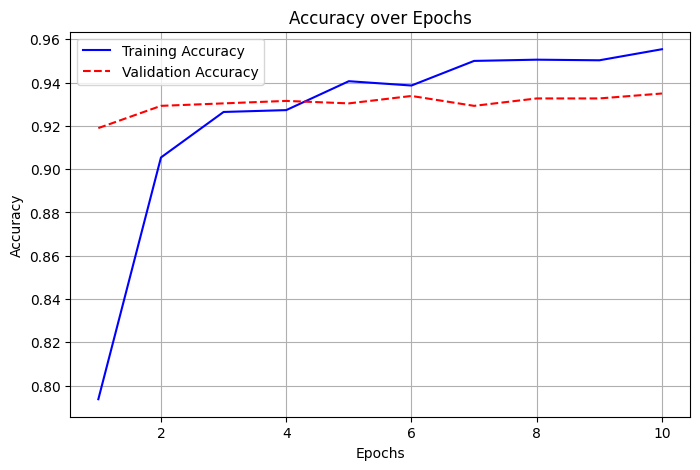

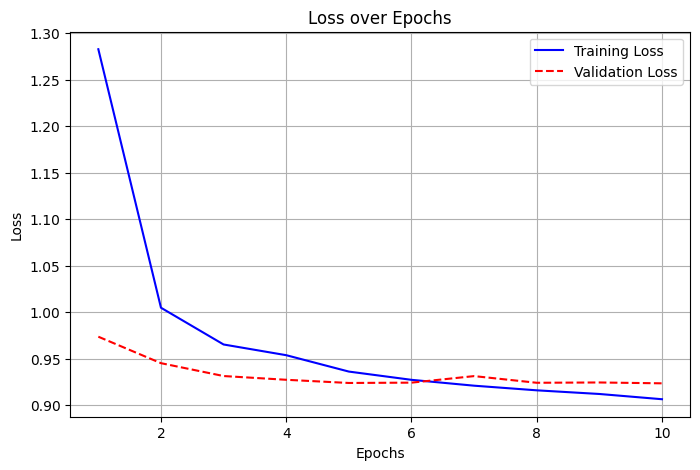

In [6]:
'''
Generates accuracy vs epoch and loss vs epoch plot for analysis
'''

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# generating accuracy vs epoch plot
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# generating loss vs epoch plot
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 381ms/step


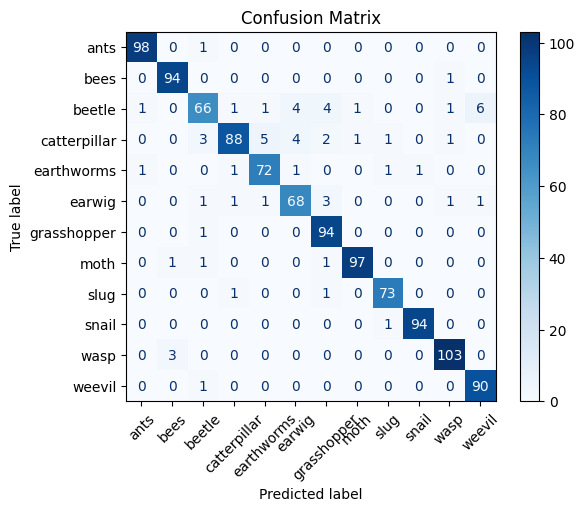

In [7]:
'''
Generates confusion matrix for analysis
'''

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_data.class_indices.keys()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


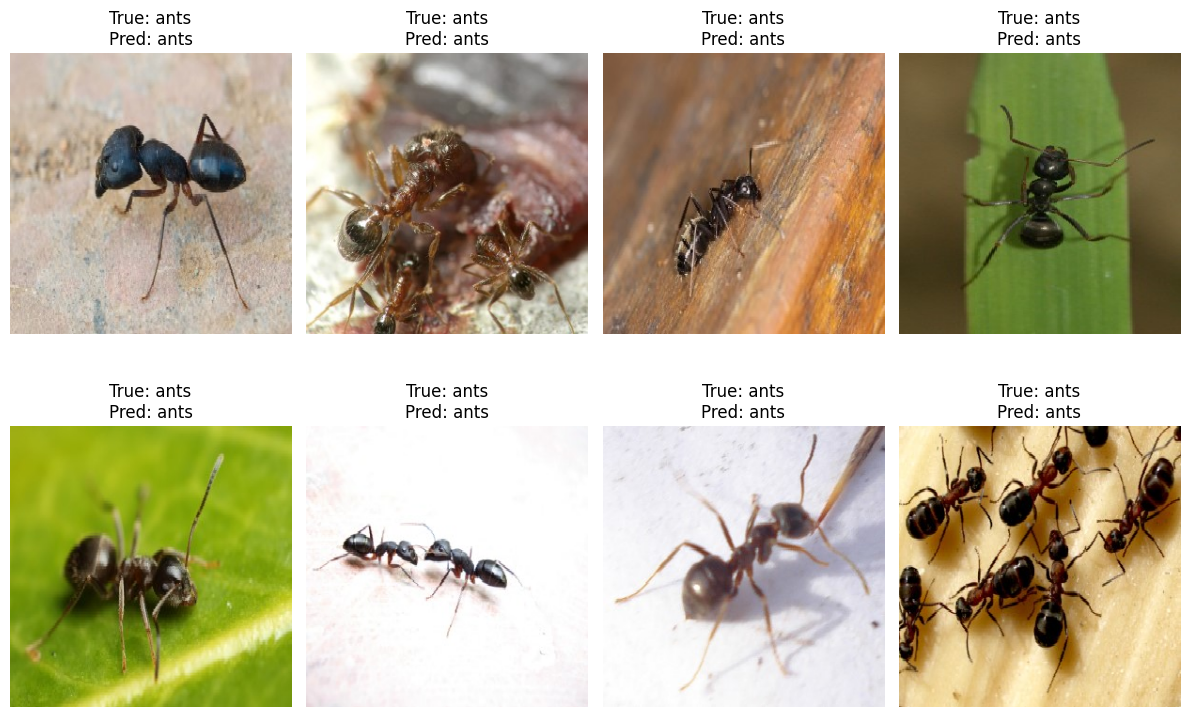

In [11]:
'''
Generates 8 prediction examples from existing model.
'''

import matplotlib.pyplot as plt

# running predictions
test_data.reset()
images, labels = next(test_data)

preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)
class_names = list(test_data.class_indices.keys())

# displaying results
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = images[i]
    if img.dtype.kind == "f":
        max_val = img.max()
        if max_val > 1.0:
            img = img / 255.0

    plt.imshow(img)
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
'''
generates post training precision, recall, and f1 score stats
'''

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# generating stats
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 380ms/step
Precision: 0.9438
Recall:    0.9436
F1 Score:  0.9427
